# ISA on scclevr with MyBigResNet as encoder

Using the common Evalution Framework, I like to compare it to the benchmark ISA!

This is a bigger ResNet then the "MyResNet" but also does not use bottleneck tecinque.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_prev = 'isa-scclevr-EncStudy-myBigResNet'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [4]:
m = InvariantSlotAttention(**hps)

Using MyBigResNet to encode data.


In [5]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

loss  tot  min:  0.026217175647616386  at  14758
loss  bce  min:  0.008798770606517792  at  14715
loss  mse  min:  0.005256034433841705  at  14996


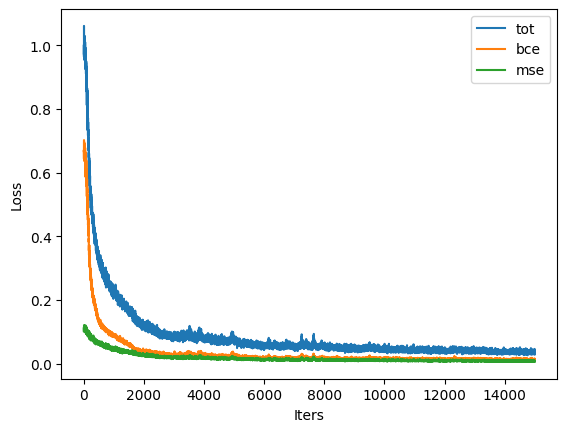

In [6]:
for k,v in losses.items():
    plt.plot(v,label=k)
    print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
lastIter = 15000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 15000


<All keys matched successfully>

### Evaluate the model

Use the common evaluation framework

In [8]:
import scclevr
os.sys.path.append('./../../../evaluation')
from dataset import TestDataset
import model_performance as ev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
ds = TestDataset()
X = torch.FloatTensor(ds.event_images).to(device)

In [10]:
with torch.no_grad():
    queries, att, Y_pred = m(X) 

In [11]:
mp = ev.Model_performance(ds, att)
mp.hungarian_matching()

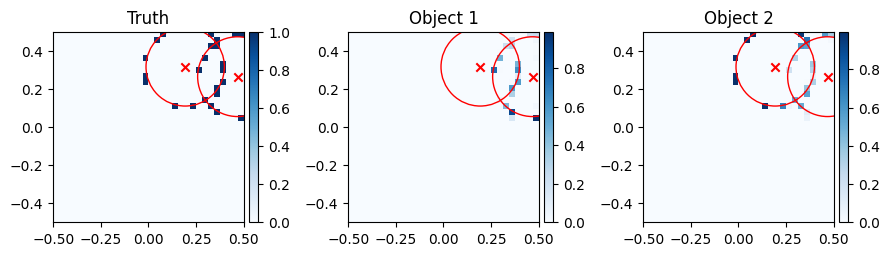

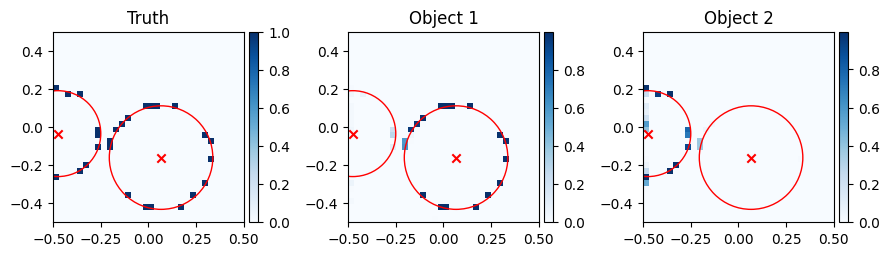

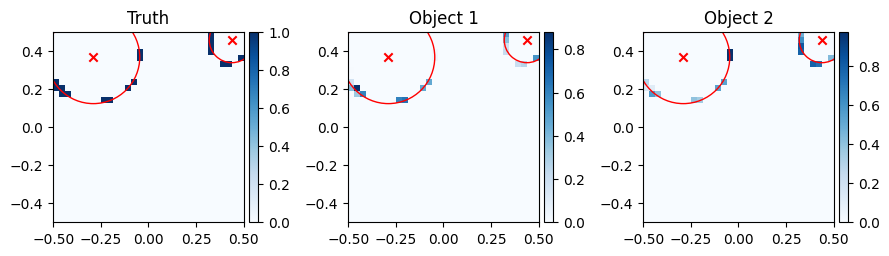

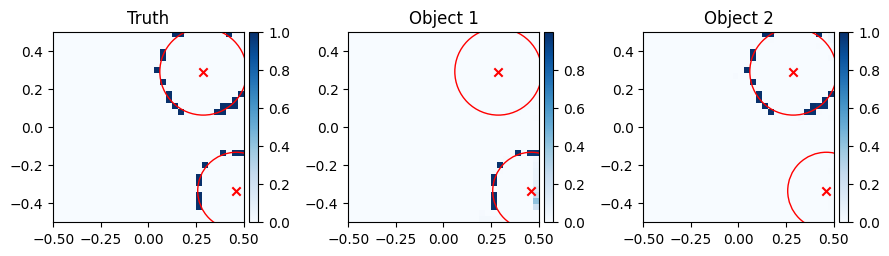

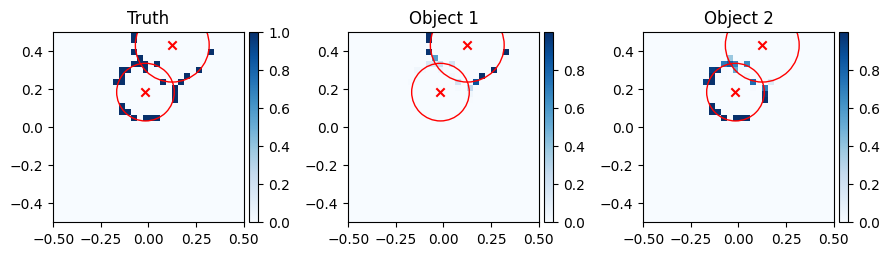

In [12]:
for i in range(5):
    mp.plot_instance_i(i)

In [13]:
loss = mp.KL_loss()
np.log10(loss)

tensor(-3.6145)

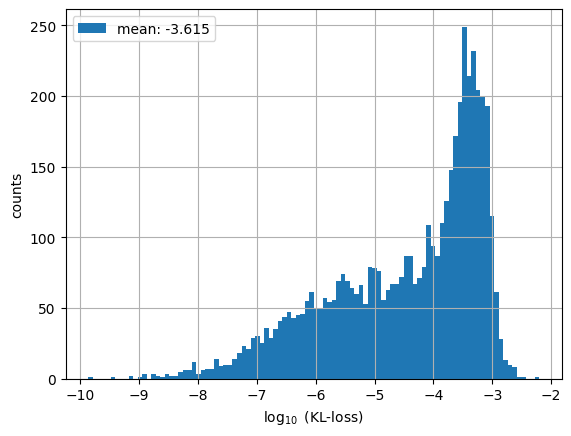

In [16]:
n, bins = mp.loss_hist()

Mhhhh .... Best network until now and still not as good as Florians...why?



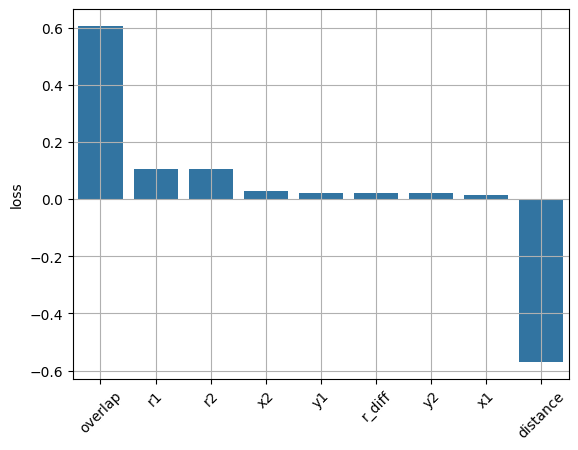

overlap     0.606010
r1          0.105087
r2          0.103846
x2          0.027725
y1          0.022930
r_diff      0.022709
y2          0.020928
x1          0.014854
distance   -0.569875
Name: loss, dtype: float64

In [21]:
mp.Pearson_correlation_coefficients()

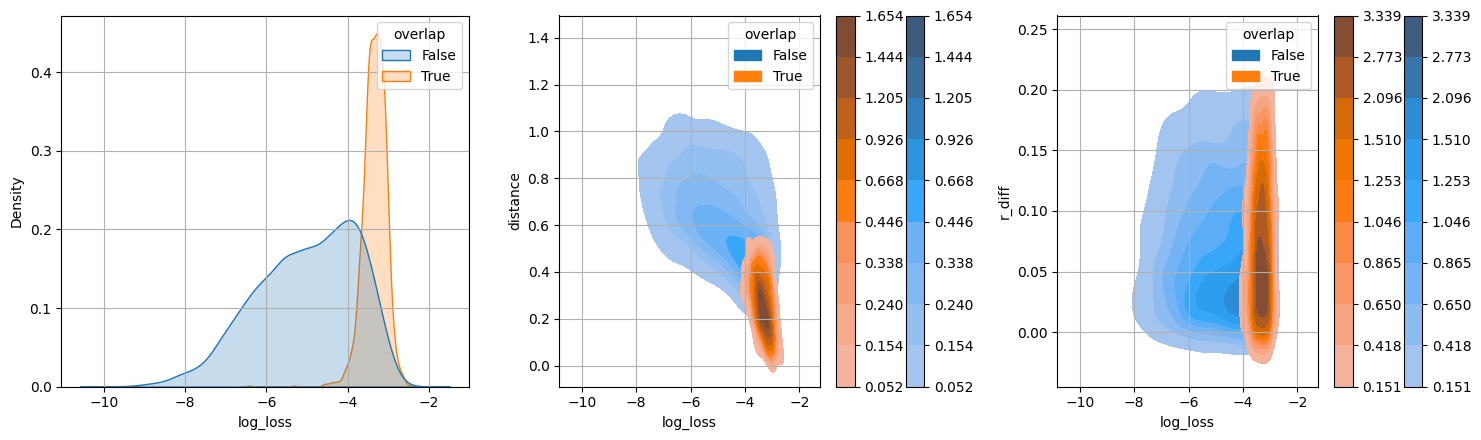

In [25]:
mp.KDE_hist()